In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import pandas_ta as ta
import math
import tensorflow as tf

In [2]:
data = pd.read_csv("MSFT.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,47894400
...,...,...,...,...,...,...,...
9466,2023-10-04,314.029999,320.040009,314.000000,318.959991,318.959991,20720100
9467,2023-10-05,319.089996,319.980011,314.899994,319.359985,319.359985,16965600
9468,2023-10-06,316.549988,329.190002,316.299988,327.260010,327.260010,25645500
9469,2023-10-09,324.750000,330.299988,323.179993,329.820007,329.820007,19891200


In [3]:
data["log_ret"] = np.log(data.Close) - np.log(data.Close.shift(1))
data["RSILR"] =ta.rsi(data.log_ret, length=15)
data["EMAFLR"]=ta.ema(data.log_ret, length=25)
data["EMAMLR"]=ta.ema(data.log_ret, length=100)
data["EMASLR"]=ta.ema(data.log_ret, length=150)
    

data["log_ret_next"] = data["log_ret"].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)
dates = data["Date"]
data.drop(["Volume", "Close", "Date", "index", "Open", "High", "Low", "Adj Close"], axis=1, inplace=True)
data

,log_ret,RSILR,EMAFLR,EMAMLR,EMASLR,log_ret_next
0,0.015037,50.994754,0.007848,0.002803,0.001204,0.043808
1,0.043808,54.276260,0.010614,0.003615,0.001768,0.000000
2,0.000000,48.930938,0.009798,0.003543,0.001745,0.028169
3,0.028169,52.175763,0.011211,0.004031,0.002094,0.006920
4,0.006920,49.627265,0.010881,0.004088,0.002158,0.040544
...,...,...,...,...,...,...
9316,-0.026482,44.596048,-0.002368,-0.000393,0.000106,0.017617
9317,0.017617,53.682327,-0.000831,-0.000036,0.000338,0.001253
9318,0.001253,50.396331,-0.000671,-0.000011,0.000350,0.024436
9319,0.024436,54.613343,0.001261,0.000473,0.000669,0.007792


In [4]:
from sklearn.preprocessing import MinMaxScaler # as using NN feed model with between 1 or 0
sc = MinMaxScaler(feature_range=(0,1))
data_scaled = sc.fit_transform(data)
print(data_scaled)
pd.DataFrame(data_scaled)

[[0.69525585 0.58454283 0.73646855 0.5860295  0.50466096 0.74883134]
 [0.74883134 0.65774016 0.78608436 0.62794095 0.54250304 0.66725528]
 [0.66725528 0.5385073  0.77143917 0.62424619 0.54093275 0.7197093 ]
 ...
 [0.66958902 0.57119438 0.58366793 0.44080763 0.44741002 0.71275802]
 [0.71275802 0.66525915 0.61830883 0.46579447 0.4688037  0.68176503]
 [0.68176503 0.59048424 0.62732057 0.4732748  0.47513059 0.6591642 ]]


,0,1,2,3,4,5
0,0.695256,0.584543,0.736469,0.586030,0.504661,0.748831
1,0.748831,0.657740,0.786084,0.627941,0.542503,0.667255
2,0.667255,0.538507,0.771439,0.624246,0.540933,0.719709
3,0.719709,0.610886,0.796787,0.649416,0.564403,0.680141
4,0.680141,0.554040,0.790866,0.652369,0.568689,0.742752
...,...,...,...,...,...,...
9316,0.617943,0.441813,0.553217,0.421082,0.431043,0.700061
9317,0.700061,0.644492,0.580792,0.439490,0.446597,0.669589
9318,0.669589,0.571194,0.583668,0.440808,0.447410,0.712758
9319,0.712758,0.665259,0.618309,0.465794,0.468804,0.681765


In [5]:
X = []

backtest = 5
for j in range(5): # number of rows of inputs
    X.append([])
    for i in range(backtest, data_scaled.shape[0]):
        X[j].append(data_scaled[i-backtest:i, j])

#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])

In [6]:
X, y = np.array(X), np.array(data_scaled[backtest:,-2:-1])
y = np.reshape(y,(len(y),1))
X.shape #9316 rows of 5 days of 5 inputs

(9316, 5, 5)

In [7]:
y.shape

(9316, 1)

In [8]:
q_80 = round(int(X.shape[0]) * 0.8)
q_90 = round(int(X.shape[0]) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

In [9]:
def adapt_learning_rate(epoch):
    if epoch <= 10:
        return 0.001
    else:
        return 0.0001
from tensorflow.keras.callbacks import ModelCheckpoint
my_lr_scheduler = tf.keras.callbacks.LearningRateScheduler(adapt_learning_rate)

In [10]:
import tensorflow as tf
import keras
from keras.optimizers import Adam, RMSprop
from keras.callbacks import History
from keras.models import Model
from keras import layers
from keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint

cp = ModelCheckpoint("stationary3/", save_best_only=True)
model = Sequential([layers.Input((backtest, 5), name="input"),
                    layers.LSTM(150),
                    layers.Dense(1, name = "Dense_layer"),
                    layers.Activation("linear", name = "output")])

model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks = [my_lr_scheduler, cp])

Epoch 1/20
231/233 [============================>.] - ETA: 0s - loss: 0.0044INFO:tensorflow:Assets written to: stationary3\assets


INFO:tensorflow:Assets written to: stationary3\assets


233/233 [==============================] - 5s 15ms/step - loss: 0.0044 - val_loss: 0.0016 - lr: 0.0010
Epoch 2/20
228/233 [============================>.] - ETA: 0s - loss: 0.0015INFO:tensorflow:Assets written to: stationary3\assets


INFO:tensorflow:Assets written to: stationary3\assets


233/233 [==============================] - 3s 14ms/step - loss: 0.0015 - val_loss: 3.6545e-04 - lr: 0.0010
Epoch 3/20
226/233 [============================>.] - ETA: 0s - loss: 0.0011INFO:tensorflow:Assets written to: stationary3\assets


INFO:tensorflow:Assets written to: stationary3\assets


233/233 [==============================] - 3s 14ms/step - loss: 0.0011 - val_loss: 2.6884e-04 - lr: 0.0010
Epoch 4/20
233/233 [==============================] - 1s 5ms/step - loss: 9.2034e-04 - val_loss: 3.0556e-04 - lr: 0.0010
Epoch 5/20
230/233 [============================>.] - ETA: 0s - loss: 8.3902e-04INFO:tensorflow:Assets written to: stationary3\assets


INFO:tensorflow:Assets written to: stationary3\assets


233/233 [==============================] - 4s 15ms/step - loss: 8.4321e-04 - val_loss: 1.6450e-04 - lr: 0.0010
Epoch 6/20
233/233 [==============================] - 1s 5ms/step - loss: 7.8566e-04 - val_loss: 6.5076e-04 - lr: 0.0010
Epoch 7/20
233/233 [==============================] - 1s 5ms/step - loss: 7.2513e-04 - val_loss: 3.5979e-04 - lr: 0.0010
Epoch 8/20
233/233 [==============================] - 1s 5ms/step - loss: 7.0964e-04 - val_loss: 4.3220e-04 - lr: 0.0010
Epoch 9/20
233/233 [==============================] - 1s 5ms/step - loss: 6.8805e-04 - val_loss: 7.9906e-04 - lr: 0.0010
Epoch 10/20
233/233 [==============================] - 1s 5ms/step - loss: 6.2985e-04 - val_loss: 3.3015e-04 - lr: 0.0010
Epoch 11/20
224/233 [===========================>..] - ETA: 0s - loss: 6.3137e-04INFO:tensorflow:Assets written to: stationary3\assets


INFO:tensorflow:Assets written to: stationary3\assets


233/233 [==============================] - 3s 14ms/step - loss: 6.4105e-04 - val_loss: 1.5387e-04 - lr: 0.0010
Epoch 12/20
233/233 [==============================] - 1s 5ms/step - loss: 4.1960e-04 - val_loss: 1.5973e-04 - lr: 1.0000e-04
Epoch 13/20
233/233 [==============================] - 1s 5ms/step - loss: 4.1714e-04 - val_loss: 1.5513e-04 - lr: 1.0000e-04
Epoch 14/20
233/233 [==============================] - 1s 5ms/step - loss: 4.1549e-04 - val_loss: 1.5774e-04 - lr: 1.0000e-04
Epoch 15/20
233/233 [==============================] - 1s 5ms/step - loss: 4.1642e-04 - val_loss: 1.5722e-04 - lr: 1.0000e-04
Epoch 16/20
233/233 [==============================] - 1s 5ms/step - loss: 4.1504e-04 - val_loss: 1.5557e-04 - lr: 1.0000e-04
Epoch 17/20
233/233 [==============================] - 1s 5ms/step - loss: 4.1428e-04 - val_loss: 1.5484e-04 - lr: 1.0000e-04
Epoch 18/20
233/233 [==============================] - 1s 5ms/step - loss: 4.1384e-04 - val_loss: 1.5764e-04 - lr: 1.0000e-04
Epoch 1

In [11]:
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

30/30 [==============================] - 0s 2ms/step


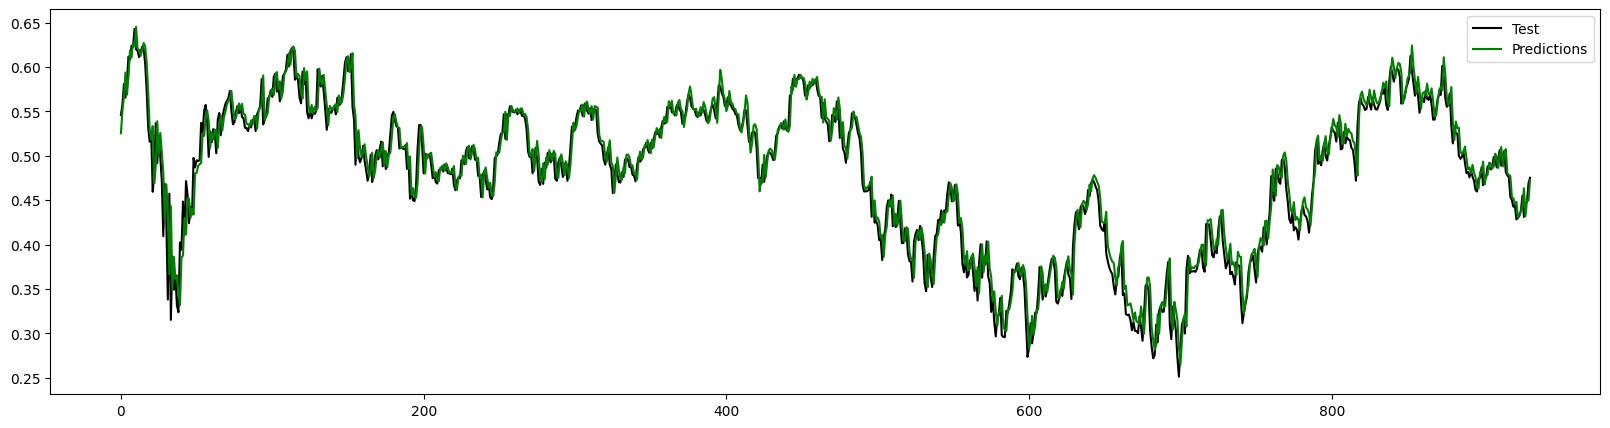

In [12]:
plt.figure(figsize=(20,5))
plt.plot(y_test, color = "black", label = "Test")
plt.plot(test_predictions, color = "green", label = "Predictions")
plt.legend()
plt.show()

In [11]:
from keras.models import load_model

filename = "stationary3"
model = load_model(filename)